In [22]:
# IMPORTS

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import xgboost as xgb

pd.options.mode.chained_assignment = None  # Disable SettingWithCopyWarning

from scipy.stats import truncnorm


In the cell below, we generate a salary dataset. The features such as age, department, and last promotion years are generated from specified distributions. There is also a "fake low variance feature" that is generated, to  later show how to remove low variance features. There is also a fake "correlated" feature that is heavily correlated with another feature, to also show how to remove it.

The salary is then explicitly calculated from the generated features, with noise added in. The relation between salary and the features is what we will then use machine learning to try to figure out, using regression.

In [ ]:
def induce_nans(df, percentage=3, columns=None):
    """
    Induces NaN values into a dataframe by a specified percentage.

    Parameters:
    - df: The dataframe where NaNs will be induced.
    - percentage: The percentage of NaN values to introduce (between 0 and 100).
    - columns: List of column names to target. If None, all columns will be considered.

    Returns:
    - DataFrame with NaNs induced at the specified percentage.
    """
    # Ensure the percentage is valid
    if not (0 <= percentage <= 100):
        raise ValueError("Percentage must be between 0 and 100.")

    # Default to all columns if no specific columns are provided
    if columns is None:
        columns = df.columns

    # Create a copy of the dataframe to avoid modifying the original
    df_copy = df.copy()

    # Loop through specified columns
    for col in columns:
        # Generate a boolean mask for where NaNs should go
        nan_mask = np.random.rand(len(df_copy)) < (percentage / 100)
        df_copy.loc[nan_mask, col] = np.nan

    return df_copy

# Function to generate truncated normal distribution
def truncated_normal(mean, std, lower, upper, size):
    return truncnorm(
        (lower - mean) / std, (upper - mean) / std, loc=mean, scale=std
    ).rvs(size)


n = 100000  # Sample size

# Generate data
df = pd.DataFrame({
    'Age': truncated_normal(mean=35, std=10, lower=20, upper=60, size=n).astype(int),
    'Bonus': truncated_normal(mean=5000, std=2000, lower=1000, upper=10000, size=n).astype(int),
    'Last_Promotion_Year': np.random.randint(2000, 2023, size=n),
    'Department': np.random.choice(['HR', 'IT', 'Finance'], size=n),
    'Performance_Score': np.random.choice(['A', 'B', 'C', 'D', 'E'], size=n),
    'X4': np.zeros(n)  # Low-variance feature
})

# Generate a correlated feature
df['Correlated'] = 2 * df['Bonus'] + np.random.normal(0, 10, size=n)

# Salary function with categorical + numerical dependencies
salaries = []
for _, row in df.iterrows():
    base_salary = 30000  # Base salary
    
    # Age impact (older employees tend to have higher salaries)
    age_factor = (row['Age'] - 20) * 800  
    
    # Bonus contribution
    bonus_factor = row['Bonus'] * 0.8  
    
    # Promotion effect (more recent promotions suggest career growth)
    years_since_promotion = 2025 - row['Last_Promotion_Year']
    promotion_factor = max(0, 5000 - (years_since_promotion * 300))  # More recent = higher boost
    
    # Department effect
    if row['Department'] == 'IT':
        dept_factor = 15000
    elif row['Department'] == 'Finance':
        dept_factor = 12000
    else:  # HR
        dept_factor = 5000
    
    # Performance Score impact
    performance_factor = {
        'A': 10000,
        'B': 7000,
        'C': 4000,
        'D': 2000,
        'E': 0
    }[row['Performance_Score']]
    
    # Compute final salary
    salary = base_salary + age_factor + bonus_factor + promotion_factor + dept_factor + performance_factor
    salary += np.random.normal(0, 5000)  # Add noise
    salaries.append(int(salary))

df['Salary'] = salaries  # Assign salaries to DataFrame

df = induce_nans(df) # make it so that there are values missing in the data

df.describe()

,Age,Bonus,Last_Promotion_Year,X4,Correlated,Salary
count,97001.000000,96971.000000,96909.000000,97088.0,96925.000000,97035.000000
mean,35.692364,5067.395768,2011.040161,0.0,10138.190747,63173.634184
std,8.537549,1836.327063,6.637296,0.0,3671.990441,10310.358516
min,20.000000,1000.000000,2000.000000,0.0,1985.268918,22016.000000
25%,29.000000,3736.000000,2005.000000,0.0,7476.037558,56094.500000
50%,35.000000,5032.000000,2011.000000,0.0,10068.287157,63013.000000
75%,42.000000,6346.000000,2017.000000,0.0,12696.186101,70150.000000
max,59.000000,9998.000000,2022.000000,0.0,20004.270630,103497.000000


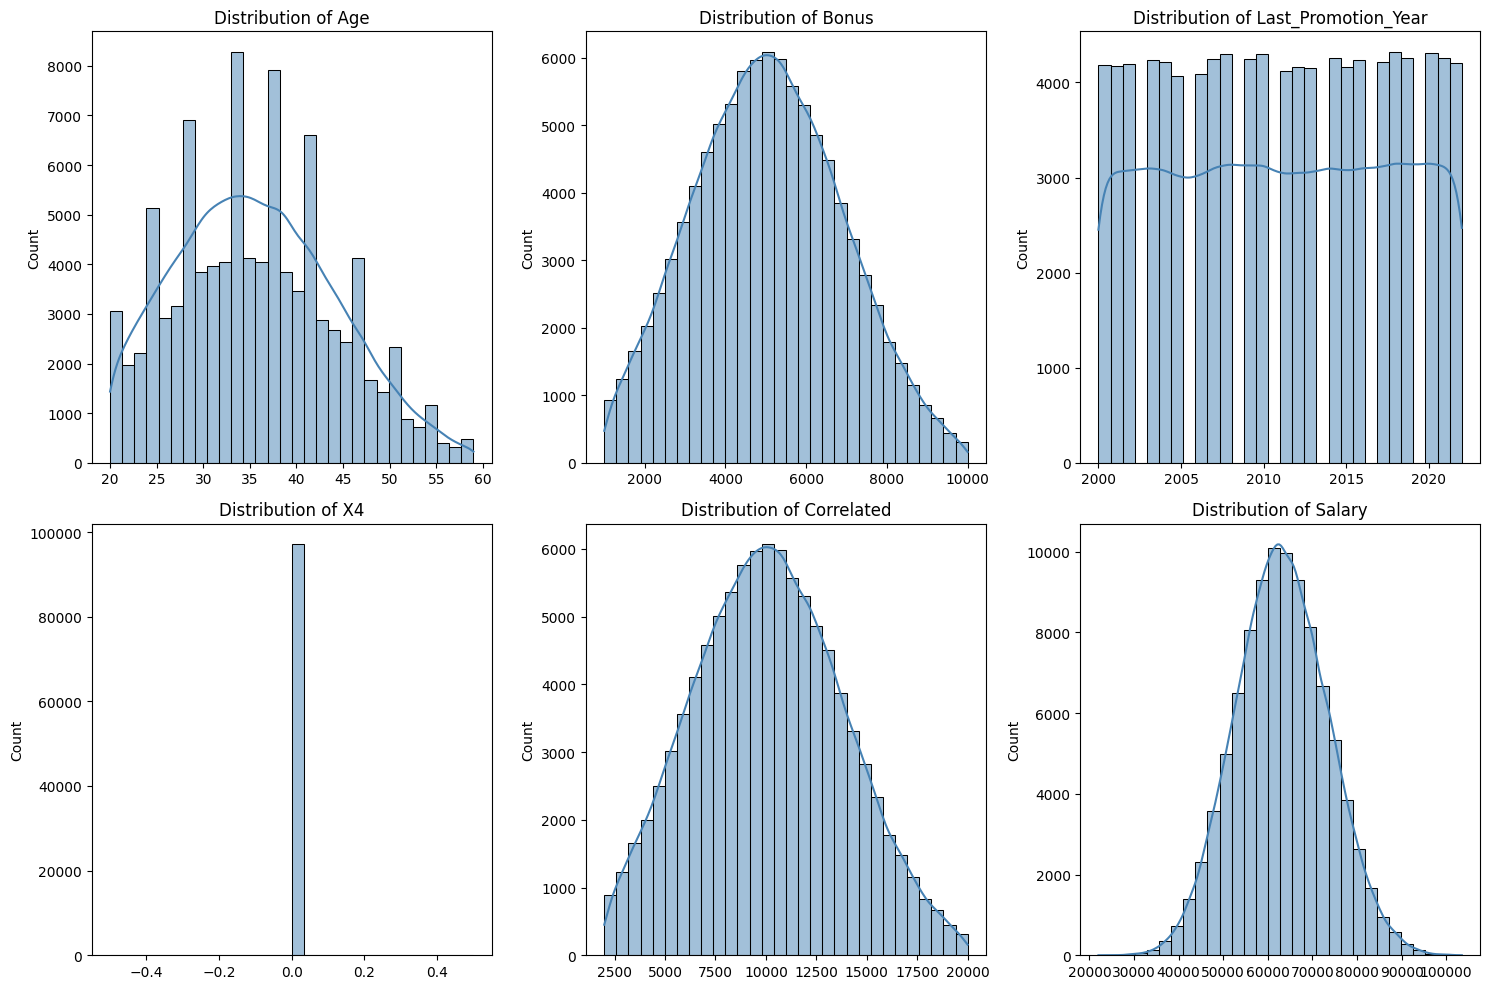

In [ ]:
def plot_numerical_distributions(df, bins=30):
    """
    Plots the distribution of all numerical features in the given DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing numerical features.
    bins (int): Number of bins for histograms (default: 30).
    """
    num_cols = df.select_dtypes(include=['number']).columns  # Select numerical columns
    num_features = len(num_cols)

    if num_features == 0:
        print("No numerical features found in the DataFrame.")
        return

    # Define the number of rows and columns for subplots
    rows = (num_features + 2) // 3  # 3 plots per row
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))  # Dynamic grid
    axes = axes.flatten() if num_features > 1 else [axes]  # Flatten if multiple plots

    for i, col in enumerate(num_cols):
        sns.histplot(df[col].dropna(), bins=bins, kde=True, ax=axes[i], color="steelblue")
        axes[i].set_title(f"Distribution of {col}", fontsize=12)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Count")

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_numerical_distributions(df)

In [7]:
# look at columns
print('Columns present in data:\n---')
for col in df.columns:
    print(col)

Columns present in data:
---
Age
Bonus
Last_Promotion_Year
Department
Performance_Score
X4
Correlated
Salary


In [11]:
print('Datatype of columns present in data:\n---')
for col in df.columns:
    print(f'{col}, {df[col].dtype}')


# define feature groups
ordinal_features = ['Performance_Score']
nominal_features = ['Department']
numeric_features = df.select_dtypes(include=['number']).columns.tolist()

print('numeric features are:',numeric_features)

Datatype of columns present in data:
---
Age, float64
Bonus, float64
Last_Promotion_Year, float64
Department, object
Performance_Score, object
X4, float64
Correlated, float64
Salary, float64
numeric features are: ['Age', 'Bonus', 'Last_Promotion_Year', 'X4', 'Correlated', 'Salary']


In [12]:
# look at correlations between features

# first need to impute and encode
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
nominal_encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
ordinal_encoder = OrdinalEncoder()

# impute missing values
df_num_imputed = pd.DataFrame(num_imputer.fit_transform(df[numeric_features]),columns = numeric_features)
df_cat_imputed = pd.DataFrame(cat_imputer.fit_transform(df[ordinal_features+nominal_features]),columns = ordinal_features+nominal_features)

df_cat_imputed.describe()

,Performance_Score,Department
count,100000,100000
unique,5,3
top,A,IT
freq,22520,35440


In [14]:
# now need to do OrdinalEncoding on performancescore and OneHotEncoding on department

# cat encoding
nominal_encoded_array = nominal_encoder.fit_transform(df_cat_imputed[nominal_features])
ordinal_encoded_array = ordinal_encoder.fit_transform(df_cat_imputed[ordinal_features])

df_nominal_encoded = pd.DataFrame(nominal_encoded_array,columns=nominal_encoder.get_feature_names_out(nominal_features))
df_ordinal_encoded = pd.DataFrame(ordinal_encoded_array,columns=ordinal_encoder.get_feature_names_out(ordinal_features))

df_encoded = df_nominal_encoded.join(df_ordinal_encoded)
df_encoded = df_encoded.join(df_num_imputed)

df_encoded.describe() # now ready to do cross correlation stuff

,Department_Finance,Department_HR,Department_IT,Performance_Score,Age,Bonus,Last_Promotion_Year,X4,Correlated,Salary
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000
mean,0.321550,0.324050,0.354400,1.935760,35.671600,5066.323630,2011.038920,0.0,10136.041212,63168.871380
std,0.467074,0.468021,0.478333,1.434982,8.409382,1808.311931,6.533914,0.0,3615.112342,10156.392324
min,0.000000,0.000000,0.000000,0.000000,20.000000,1000.000000,2000.000000,0.0,1985.268918,22016.000000
25%,0.000000,0.000000,0.000000,1.000000,29.000000,3786.000000,2005.000000,0.0,7576.200705,56344.750000
50%,0.000000,0.000000,0.000000,2.000000,35.000000,5032.000000,2011.000000,0.0,10068.287157,63013.000000
75%,1.000000,1.000000,1.000000,3.000000,41.000000,6295.000000,2017.000000,0.0,12592.008677,69901.000000
max,1.000000,1.000000,1.000000,4.000000,59.000000,9998.000000,2022.000000,0.0,20004.270630,103497.000000


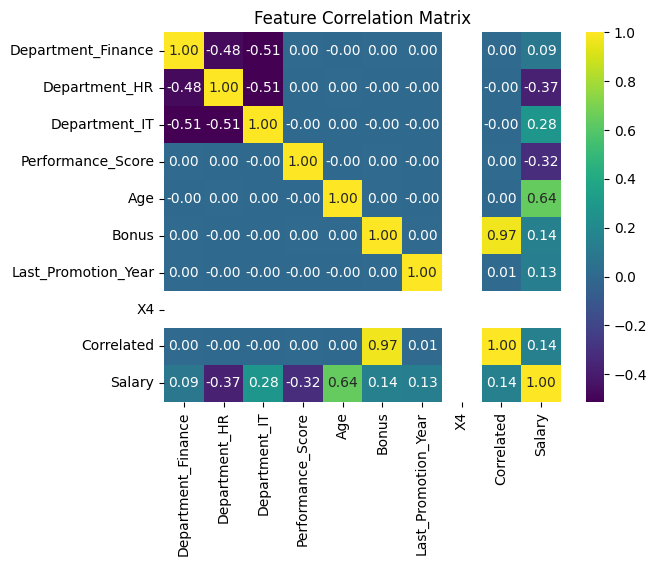

In [15]:
# look at correlation between features and variance of features

plt.figure()
sns.heatmap(df_encoded.corr(), annot=True,cmap='viridis',fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

[]


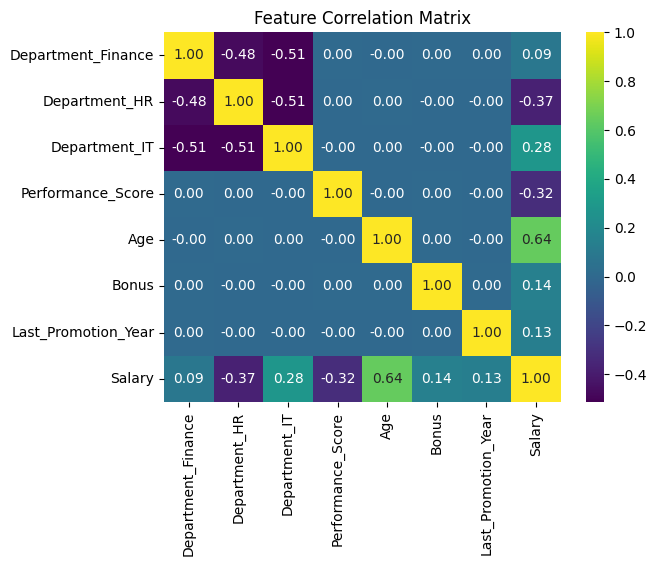

In [18]:
# now remove the correlated and low variance

corr_threshold = 0.9
corr_matrix = df_encoded.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > corr_threshold)]

# syntax is: [expression for item in iterable if condition]

# drop correlated features
df_encoded = df_encoded.drop(columns=to_drop)
print(to_drop)

# now do low variance features
var_thresh = VarianceThreshold(threshold=0.01)
X_filtered = var_thresh.fit_transform(df_encoded)
selected_columns = df_encoded.columns[var_thresh.get_support()]

df_encoded = pd.DataFrame(X_filtered,columns = selected_columns)

plt.figure()
sns.heatmap(df_encoded.corr(), annot=True,cmap='viridis',fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

In [19]:
df.describe()

,Age,Bonus,Last_Promotion_Year,X4,Correlated,Salary
count,97001.000000,96971.000000,96909.000000,97088.0,96925.000000,97035.000000
mean,35.692364,5067.395768,2011.040161,0.0,10138.190747,63173.634184
std,8.537549,1836.327063,6.637296,0.0,3671.990441,10310.358516
min,20.000000,1000.000000,2000.000000,0.0,1985.268918,22016.000000
25%,29.000000,3736.000000,2005.000000,0.0,7476.037558,56094.500000
50%,35.000000,5032.000000,2011.000000,0.0,10068.287157,63013.000000
75%,42.000000,6346.000000,2017.000000,0.0,12696.186101,70150.000000
max,59.000000,9998.000000,2022.000000,0.0,20004.270630,103497.000000


In [20]:
df_analysis = df.drop(columns=to_drop)

print(to_drop)
print(df_analysis.columns)

# now do low variance features
var_thresh = VarianceThreshold(threshold=0.01)
X_filtered = var_thresh.fit_transform(df_encoded)
selected_columns = df_encoded.columns[var_thresh.get_support()]

df_encoded = pd.DataFrame(X_filtered,columns = selected_columns)

df_encoded.head(10)

[]
Index(['Age', 'Bonus', 'Last_Promotion_Year', 'Department',
       'Performance_Score', 'X4', 'Correlated', 'Salary'],
      dtype='object')


,Department_Finance,Department_HR,Department_IT,Performance_Score,Age,Bonus,Last_Promotion_Year,Salary
0,0.0,0.0,1.0,3.0,26.0,6578.0,2000.0,59908.0
1,0.0,0.0,1.0,4.0,21.0,7546.0,2010.0,52261.0
2,0.0,1.0,0.0,2.0,41.0,9214.0,2013.0,61841.0
3,1.0,0.0,0.0,3.0,36.0,4009.0,2015.0,60430.0
4,1.0,0.0,0.0,2.0,40.0,5015.0,2004.0,61817.0
5,1.0,0.0,0.0,3.0,44.0,3890.0,2011.0,67663.0
6,0.0,0.0,1.0,0.0,35.0,5054.0,2002.0,76984.0
7,1.0,0.0,0.0,0.0,35.0,3553.0,2020.0,75918.0
8,1.0,0.0,0.0,4.0,51.0,6604.0,2009.0,74674.0
9,0.0,0.0,1.0,4.0,27.0,4383.0,2005.0,55398.0


In [23]:
# actually lets try it with df_encoded. only scale the numerical features

print(df_encoded.columns)

new_num_feats = ['Age','Bonus','Last_Promotion_Year']
already_encoded_feats = ['Department_Finance',
                         'Department_HR',
                         'Department_IT',
                         'Performance_Score']

# set up pipeline
num_pipeline = Pipeline([
    ('scaler',RobustScaler())
])

preprocessor = ColumnTransformer([
    ('num',num_pipeline,new_num_feats),
    ('passthrough','passthrough',already_encoded_feats)
])

# model = LinearRegression()
# model = RandomForestRegressor(n_estimators=10, random_state=1997)
model = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             random_state=1997)

salary_model = Pipeline([
    ('preprocessor',preprocessor),
    ('regressor',model)
])


Index(['Department_Finance', 'Department_HR', 'Department_IT',
       'Performance_Score', 'Age', 'Bonus', 'Last_Promotion_Year', 'Salary'],
      dtype='object')


In [24]:
# split data and train model

X = df_encoded.drop(columns=['Salary'])
y = df_encoded['Salary']

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=1997)

salary_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Bonus',
                                                   'Last_Promotion_Year']),
                                                 ('passthrough', 'passthrough',
                                                  ['Department_Finance',
                                                   'Department_HR',
                                                   'Department_IT',
                                                   'Performance_Score'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, ...))])

Mean Absolute Error (MAE): 4401.12
Mean Squared Error (MSE): 31551522.86
Root Mean Squared Error (RMSE): 5617.07
R² Score: 0.69


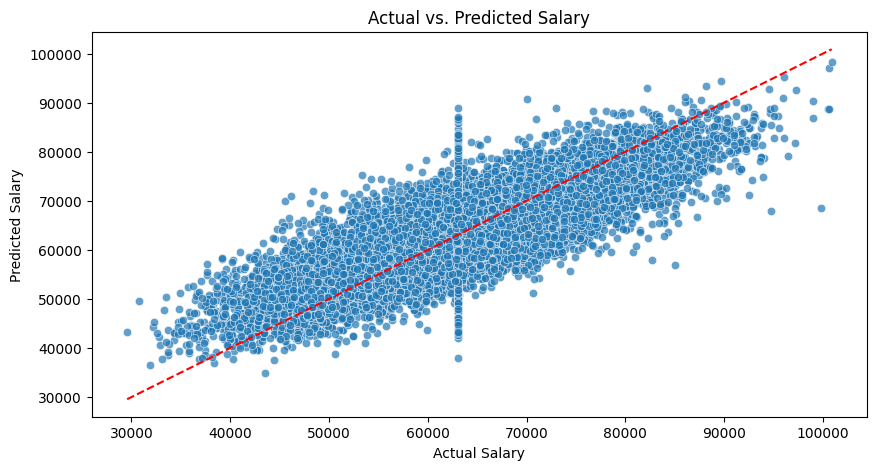

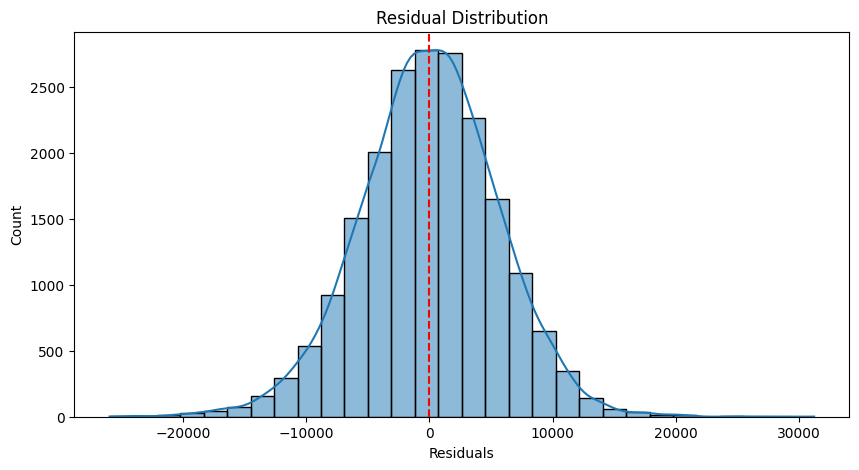

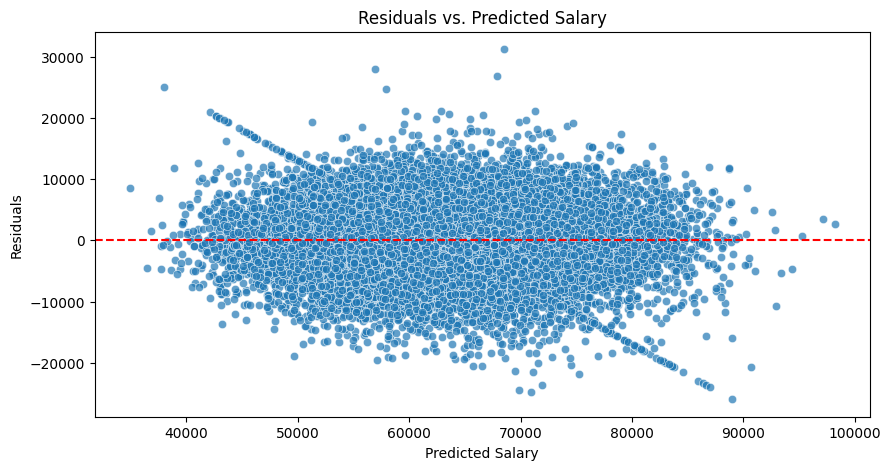

In [25]:
# now make predictions
y_predict = salary_model.predict(X_test)

# print("Model Coefficients:")
# print(salary_model.named_steps['regressor'].coef_)

# evaluate model

mae = mean_absolute_error(y_test,y_predict)
mse = mean_squared_error(y_test,y_predict)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,y_predict)

# print metrics:
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# plot Actual vs. Predicted
plt.figure(figsize=(10,5))
sns.scatterplot(x=y_test, y=y_predict, alpha=0.7)
sns.lineplot(x=y_test, y=y_test, color='red', linestyle='--')  # Ideal predictions
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs. Predicted Salary")
plt.show()

# residual Plot
residuals = y_test - y_predict

plt.figure(figsize=(10,5))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals")
plt.title("Residual Distribution")
plt.show()

# residuals vs. predictions plot
plt.figure(figsize=(10,5))
sns.scatterplot(x=y_predict, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Salary")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Salary")
plt.show()

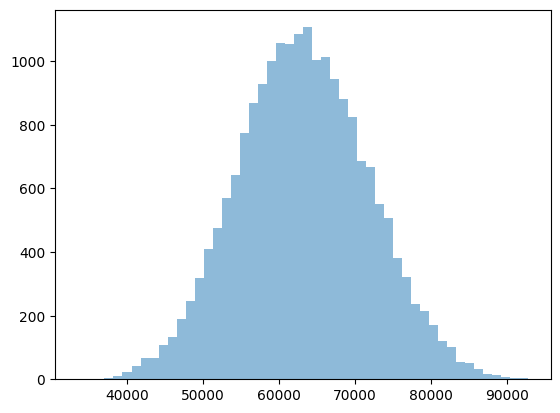

In [15]:
plt.figure()
# plt.hist(y_predict,bins = 50,alpha = 0.5,label = 'predict')
plt.hist(y_predict,bins = 50,alpha = 0.5,label = 'test')
plt.legend
plt.show()

In [16]:
# now do it with cross validation

# set up pipeline
num_pipeline = Pipeline([
    ('scaler',RobustScaler())
])

preprocessor = ColumnTransformer([
    ('num',num_pipeline,new_num_feats),
    ('passthrough','passthrough',already_encoded_feats)
])

# model = LinearRegression()
# model = RandomForestRegressor(n_estimators=10, random_state=1997)
model = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             random_state=1997)

salary_model = Pipeline([
    ('preprocessor',preprocessor),
    ('regressor',model)
])

cv_scores = cross_val_score(salary_model,X,y,
                            cv=5,
                            scoring='neg_mean_squared_error')

# since cross_val_score returns negative MSE, convert to positive
mse_scores = -cv_scores
rmse_scores = np.sqrt(mse_scores)

# print out cross-validation results
print(f"Cross-validated MSE: {mse_scores}")
print(f"Cross-validated RMSE: {rmse_scores}")
print(f"Average RMSE: {rmse_scores.mean():.2f}")

Cross-validated MSE: [31590986.87103915 31915852.14518914 31098080.41740809 30911746.97639947
 31503292.6742762 ]
Cross-validated RMSE: [5620.58599    5649.41166363 5576.56528855 5559.83335869 5612.77940723]
Average RMSE: 5603.84


In [17]:
# hyperparameter tuning

# set up hyperparameter grid
param_grid = {
    'regressor__n_estimators': [50,100,200],
    'regressor__max_depth': [3, 6, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.8, 1.0],  # fraction of samples to use for fitting trees
    'regressor__colsample_bytree': [0.8, 1.0],  # fraction of features to use for each tree
}

# # initialize gridsearchcv with xgbregressor
# model = xgb.XGBRegressor(objective='reg:squarederror',
#                              n_estimators=100,
#                              random_state=1997)
grid_search = GridSearchCV(estimator=salary_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=1,
                           verbose=1)

# fit model
grid_search.fit(X,y)

# print best params and corresponding score
print(f'best hyperparams: {grid_search.best_params_}')
best_rmse = np.sqrt(np.abs(grid_search.best_score_))
print(f'best RMSE from GridSearchCV: {best_rmse:.2f}')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
best hyperparams: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}
best RMSE from GridSearchCV: 5518.17


MAE: 4329.45
MSE: 30254244.62
RMSE: 5500.39
R²: 0.70


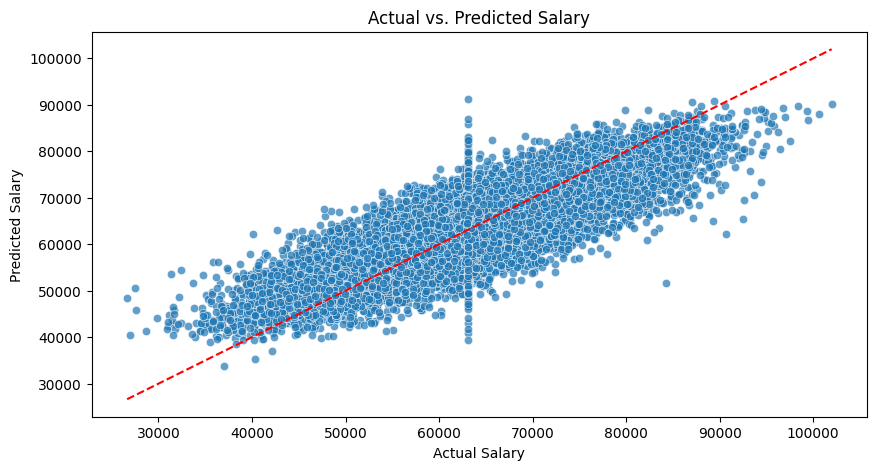

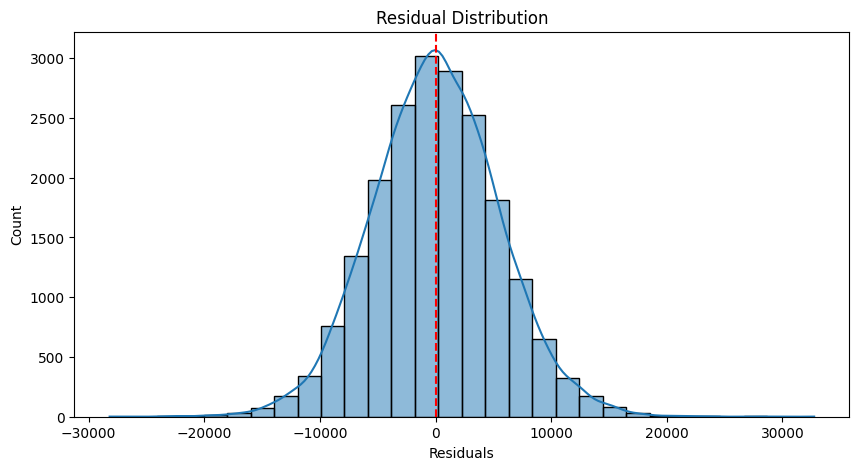

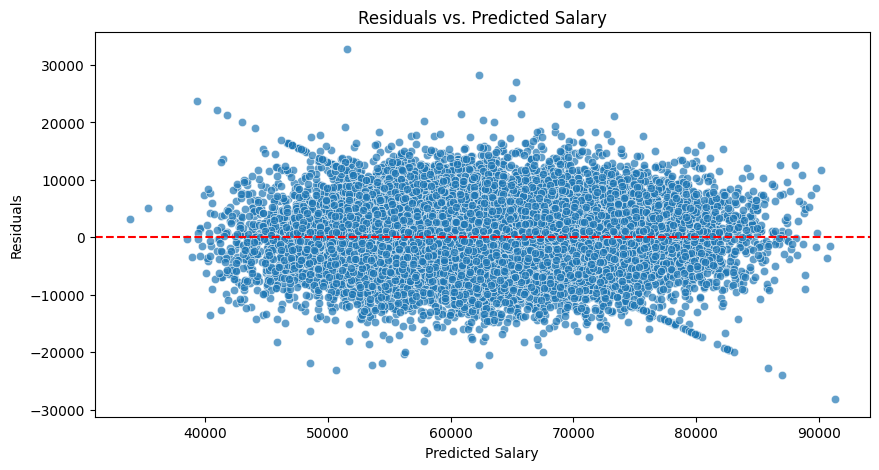

In [18]:
# now fit with the best model

best_model = grid_search.best_estimator_
best_model.fit(X_train,y_train)

y_predict_optimized = best_model.predict(X_test)


# Evaluate the model (e.g., MAE, RMSE)
mae = mean_absolute_error(y_test, y_predict_optimized)
mse = mean_squared_error(y_test, y_predict_optimized)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_predict_optimized)

# Print evaluation metrics
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# plot Actual vs. Predicted
plt.figure(figsize=(10,5))
sns.scatterplot(x=y_test, y=y_predict_optimized, alpha=0.7)
sns.lineplot(x=y_test, y=y_test, color='red', linestyle='--')  # Ideal predictions
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs. Predicted Salary")
plt.show()

# residual Plot
residuals = y_test - y_predict_optimized

plt.figure(figsize=(10,5))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals")
plt.title("Residual Distribution")
plt.show()

# residuals vs. predictions plot
plt.figure(figsize=(10,5))
sns.scatterplot(x=y_predict_optimized, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Salary")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Salary")
plt.show()

               Feature  Importance
4                  Age    0.301463
0   Department_Finance    0.262261
3    Performance_Score    0.152430
6  Last_Promotion_Year    0.146195
5                Bonus    0.111377
2        Department_IT    0.015674
1        Department_HR    0.010599


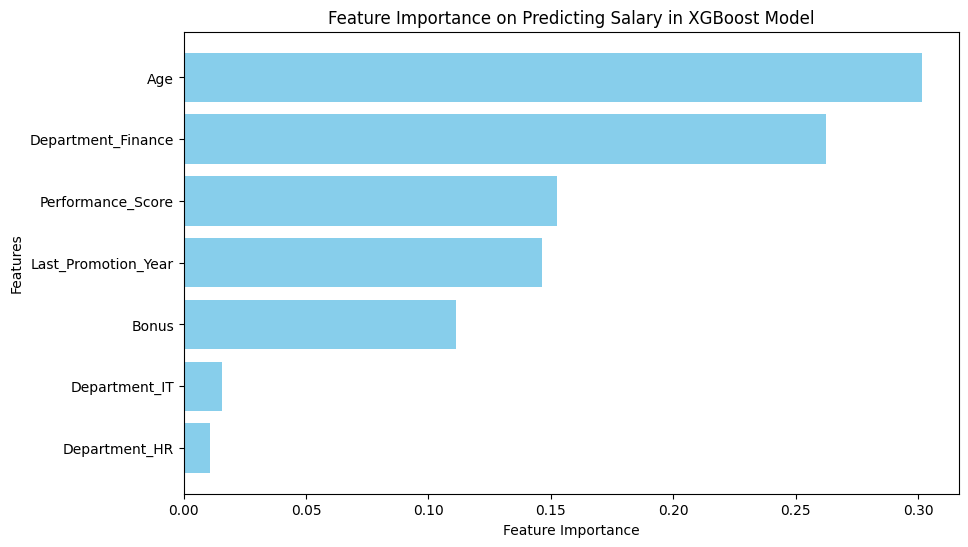

In [19]:
# feature importance

# get feature importance from best xgb model
feature_importance = best_model.named_steps['regressor'].feature_importances_

# match feature importance with feature names
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names,
                                      'Importance': feature_importance})

# sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance',ascending=False)

# print top features
print(feature_importance_df)

# plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance on Predicting Salary in XGBoost Model")
plt.gca().invert_yaxis()  # Invert axis to show highest importance at the top
plt.show()